# Biased random walks using `Node2Vec`

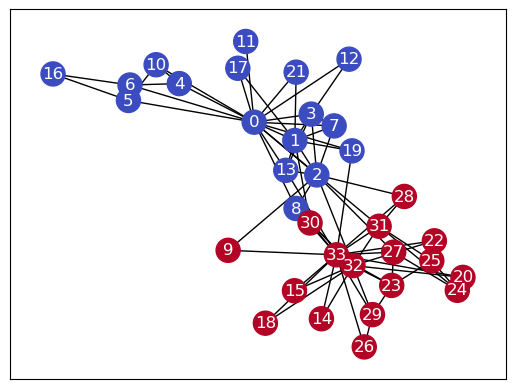

In [1]:
import networkx as nx

# Load karate dataset
G = nx.karate_club_graph()

# label officer with 1 and Mr. Hi with 0
labels =  []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(0 if label == "Mr. Hi" else 1)

# plot the karate graph with labels
nx.draw_networkx(G, node_color=labels, cmap='coolwarm', font_color="white")

In [2]:
# bias walk
from sources import utils

# random walk p = q =1
print(utils.bias_walk(G=G, start=0, length=8, p=1, q=1))
# biased walk p = 10, q=1
print(utils.bias_walk(G=G, start=0, length=8, p=10, q=1))
# biased walk p=1, q=10
print(utils.bias_walk(G=G, start=0, length=8, p=1, q=10))

[0, 19, 1, 19, 1, 30, 1, 30, 33]
[0, 31, 28, 33, 18, 32, 31, 0, 6]
[0, 11, 0, 11, 0, 11, 0, 2, 7]


In [3]:
# create list of bias walk
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(utils.bias_walk(G=G, start=node, length=10, p=3, q=2))
len(walks)

2720

In [4]:
# create Word2Vec model
try:
    from gensim.models.word2vec import Word2Vec
except:
    !pip install -qI gensim
    from gensim.models.word2vec import Word2Vec

# create model object
node2vec = Word2Vec(
    walks,
    hs=1, # hierarchical softmax
    sg=1, # skipgram,
    vector_size=100, #node embedding size
    window=10,
    workers=1,
    min_count=1
)

# train model
node2vec.train(
    walks,
    total_examples=node2vec.corpus_count,
    epochs=30,
    report_delay=1
)

(186619, 897600)

In [5]:
# accuracy metrics
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
labels = np.array(labels)

# train node2vec classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(
    node2vec.wv[train_mask],
    labels[train_mask]
)

# accuracy
y_pred = clf.predict(node2vec.wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
acc

1.0